In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/data
import re
import sklearn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split as splitter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import math
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report
tf.config.experimental_run_functions_eagerly(True)
from IPython.display import Image
# Get the interactive Tools for Matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import h5py


/content/drive/My Drive/Colab Notebooks/data


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#loading lyrics
lyrics = pd.read_csv('data.csv')
lyrics_data=list(lyrics['lyrics'].str.lower())
artist_data=list(lyrics['artist'])

In [ ]:
#pre processing
def preprocessing(data):
  processed_data=[]

  #removing everything except numbers and words
  for i in data:
    x = re.sub(r'[^a-z]+',' ',i)
    processed_data.append(x)
  
  return processed_data

processed_data = preprocessing(lyrics_data)


In [ ]:
#splitting data 
def split(data,labels):
  train_data,test_data,train_labels,test_labels=splitter(data,labels,train_size=0.8,test_size=0.2,shuffle=True)

  return train_data,train_labels,test_data,test_labels

train_data,train_labels,test_data,test_labels=split(processed_data,artist_data)

In [ ]:
#integer encoding labels
def encoded(labels):
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(labels)
  print(label_encoder.classes_)
  return np.array(integer_encoded)

encoded_train_labels = encoded(train_labels)
encoded_test_labels  = encoded(test_labels)


['Eminem' 'Geazy' 'Kendrick' 'Mgk']
['Eminem' 'Geazy' 'Kendrick' 'Mgk']


# **BOW** Model




In [ ]:
train_vectors[0]

In [ ]:
#Logistic Regression 
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_vectors, encoded_train_labels)
score = classifier.score(test_vectors, encoded_test_labels)
print('LogisticR',score)


LogisticR 0.775


In [ ]:
#SVM

Linear_SVM = svm.LinearSVC()
Linear_SVM.fit(train_vectors,encoded_train_labels)
score = Linear_SVM.score(test_vectors, encoded_test_labels)
print('one-verses-rest',score)


one-verses-rest 0.75


In [ ]:
#Naive Bayes

#making dense matrix
dense_train= csr_matrix(train_vectors)
dense_train = dense_train.todense() 
dense_test = csr_matrix(test_vectors)
dense_test = dense_test.todense()

Naive2 = MultinomialNB()
Naive2.fit(dense_train,encoded_train_labels)
score = Naive2.score(dense_test, encoded_test_labels)
print('MultinomialNB',score)





MultinomialNB 0.8375


In [ ]:
#convering to onehot
def onehot(integer_encoded):
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded= onehot_encoder.fit_transform(integer_encoded)
  return np.array(onehot_encoded)

one_encoded_train=onehot(encoded_train_labels)
one_encoded_test =onehot(encoded_test_labels)

In [ ]:
#ANN
model = Sequential()
model.add(layers.Dense(100,input_dim=12682,activation='sigmoid'))
model.add(Dropout(0.5))
model.add(layers.Dense(100,activation='sigmoid'))
model.add(Dropout(0.5))
model.add(layers.Dense(4,activation='relu'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1268300   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 1,278,804
Trainable params: 1,278,804
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_vectors.toarray(),one_encoded_train, epochs=80, batch_size=25,verbose=0,shuffle=True)

# **REPORT**

In [ ]:
Label_list=['Eminem', 'Geazy', 'Kendrick', 'Mgk']

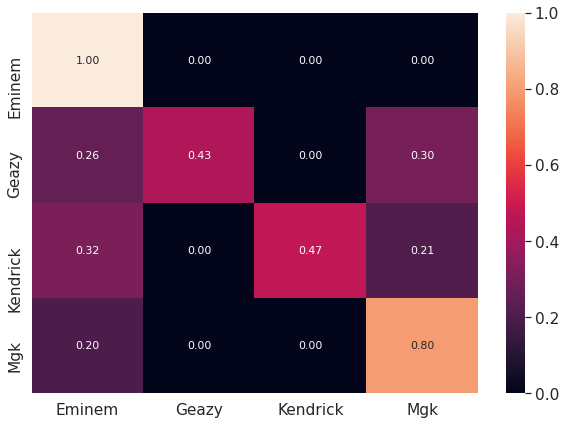

In [ ]:
#ANN
predictions1=[]
predictions = model.predict(test_vectors)
pred=[]

for i in predictions:
    pred.append(np.argmax(i))
predictions1=pred

test_Y_max=np.argmax(one_encoded_test, axis=-1)
cm=confusion_matrix(test_Y_max,predictions1)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, Label_list,Label_list )# matrix,names row,names col,
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()





In [ ]:

print("Classification Report\n",classification_report(test_Y_max, predictions1, labels=[0,1,2,3], target_names = Label_list))

Classification Report
               precision    recall  f1-score   support

      Eminem       0.61      1.00      0.75        23
       Geazy       1.00      0.43      0.61        23
    Kendrick       1.00      0.47      0.64        19
         Mgk       0.52      0.80      0.63        15

    accuracy                           0.68        80
   macro avg       0.78      0.68      0.66        80
weighted avg       0.80      0.68      0.66        80



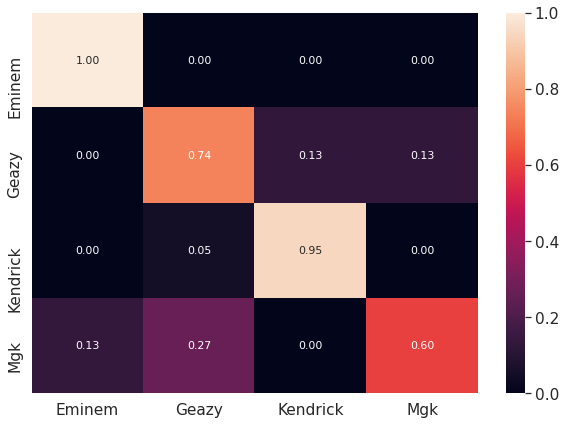

In [ ]:
#NB
predictions2 = []
predictions2 = np.array(Naive2.predict(test_vectors))


test_Y_max=np.argmax(one_encoded_test, axis=-1)
cm=confusion_matrix(test_Y_max,predictions2)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, Label_list,Label_list )# matrix,names row,names col,
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()


In [ ]:
print("Classification Report\n",classification_report(test_Y_max, predictions2, labels=[0,1,2,3], target_names = Label_list))

Classification Report
               precision    recall  f1-score   support

      Eminem       0.92      1.00      0.96        23
       Geazy       0.77      0.74      0.76        23
    Kendrick       0.86      0.95      0.90        19
         Mgk       0.75      0.60      0.67        15

    accuracy                           0.84        80
   macro avg       0.82      0.82      0.82        80
weighted avg       0.83      0.84      0.83        80



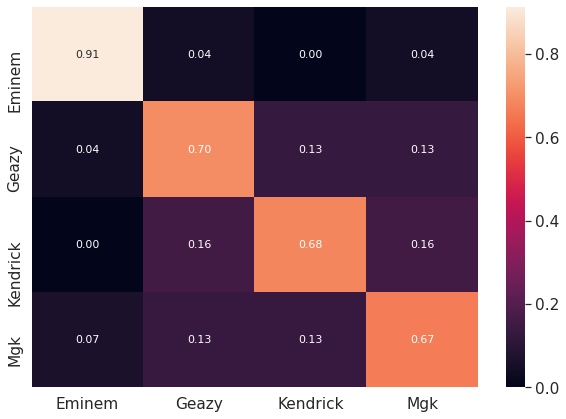

In [ ]:
#SVM
predictions3 = []
predictions3 = np.array(Linear_SVM.predict(test_vectors))


test_Y_max=np.argmax(one_encoded_test, axis=-1)
cm=confusion_matrix(test_Y_max,predictions3)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, Label_list,Label_list )# matrix,names row,names col,
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()


In [ ]:
print("Classification Report\n",classification_report(test_Y_max, predictions3, labels=[0,1,2,3], target_names = Label_list))

Classification Report
               precision    recall  f1-score   support

      Eminem       0.91      0.91      0.91        23
       Geazy       0.73      0.70      0.71        23
    Kendrick       0.72      0.68      0.70        19
         Mgk       0.59      0.67      0.62        15

    accuracy                           0.75        80
   macro avg       0.74      0.74      0.74        80
weighted avg       0.75      0.75      0.75        80



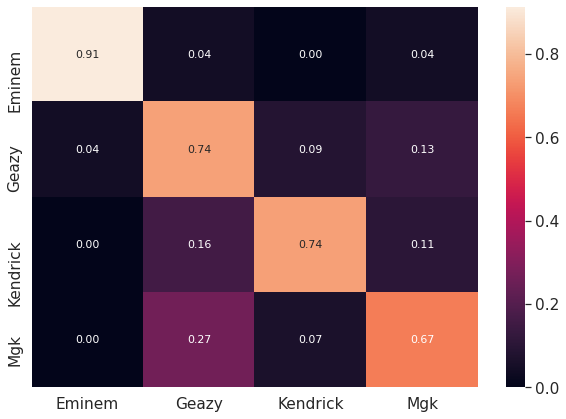

In [ ]:
#LR
predictions4 = []
predictions4 = np.array(classifier.predict(test_vectors))


test_Y_max=np.argmax(one_encoded_test, axis=-1)
cm=confusion_matrix(test_Y_max,predictions4)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, Label_list,Label_list )# matrix,names row,names col,
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()


In [ ]:
print("Classification Report\n",classification_report(test_Y_max, predictions4, labels=[0,1,2,3], target_names = Label_list))

Classification Report
               precision    recall  f1-score   support

      Eminem       0.95      0.91      0.93        23
       Geazy       0.68      0.74      0.71        23
    Kendrick       0.82      0.74      0.78        19
         Mgk       0.62      0.67      0.65        15

    accuracy                           0.78        80
   macro avg       0.77      0.76      0.77        80
weighted avg       0.78      0.78      0.78        80



#Ensembling models


In [ ]:
import numpy as np
from scipy import stats
final = []
for i in range(0,len(predictions1)):
  mode= stats.mode([predictions1[i],predictions2[i],predictions3[i],predictions4[i]])[0][0]
  final.append(mode)

In [ ]:
print("Classification Report\n",classification_report(test_Y_max, final, labels=[0,1,2,3], target_names = Label_list))

Classification Report
               precision    recall  f1-score   support

      Eminem       0.88      1.00      0.94        23
       Geazy       0.79      0.83      0.81        23
    Kendrick       0.88      0.79      0.83        19
         Mgk       0.69      0.60      0.64        15

    accuracy                           0.82        80
   macro avg       0.81      0.80      0.81        80
weighted avg       0.82      0.82      0.82        80

